In [14]:

from time import time
import numpy as np
import cPickle as pickle
import pandas as pd
from pysofia.compat import RankSVM, RankSVMCV
from sklearn.pipeline import make_pipeline, make_union
import transformers as tforms
from sklearn.preprocessing import StandardScaler

In [6]:
# Load Data custom
train_pd  = pd.read_pickle('saved/train_pd_custom.p')
test_pd  = pd.read_pickle('saved/test_pd_custom.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')

In [7]:
# Load Data le instead
# train_pd  = pd.read_pickle('saved/train_pd_l_enc.p')
# test_pd  = pd.read_pickle('saved/test_pd_l_enc.p')

train_pd  = pd.read_pickle('saved/train_pd_le_and_oh_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_le_and_oh_enc.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')
fi = np.load('saved/feature_importances.npy')

y_binned[y_binned==6] = 5

drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = []

# drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)

In [8]:
X_tsne2_26 = np.load('saved/X_tsne2_26important.npy')
X_tsne2_26_train = X_tsne2_26[:len(train_pd), :]
X_tsne2_26_test = X_tsne2_26[-len(test_pd):, :]

X_tsne2 = np.load('saved/X_tsne2.npy')
X_tsne2_train = X_tsne2[:len(train_pd), :]
X_tsne2_test = X_tsne2[-len(test_pd):, :]

print X_tsne2_train.shape
print X_tsne2_test.shape
print X_tsne2_26_train.shape
print X_tsne2_26_test.shape

(50999, 2)
(51000, 2)
(50999, 2)
(51000, 2)


In [16]:
train = np.array(train_pd)
test = np.array(test_pd)

X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)

try:
    X_train = np.c_[X_train, X_tsne2_26_train]
    X_test = np.c_[X_test, X_tsne2_26_test]
#     X_train = X_tsne2_26_train
#     X_test = X_tsne2_26_test
except:
    pass

holdout = False
if holdout:
    X_train, X_hold, \
    y_train, y_hold, \
    y_binned, y_binned_hold \
    = train_test_split(
        X_train, y_train, y_binned, 
        test_size=0.2, random_state=0)


pipe_x = make_pipeline(
    make_union(
        tforms.IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ),
    StandardScaler(),
)
pipe_y = make_pipeline(
    tforms.IdentityTformer(),
#     tforms.BoxCoxTformer(),
#     tforms.LogTformer(),
#     tforms.AnscombeTformer(),
#     tforms.FreemanTukeyTformer(),
#     tforms.ArcsinhTformer(),
#     StandardScaler(),
    
)
pipe_x.fit(np.r_[X_train, X_test])
pipe_y.fit(y_train)

X_train = pipe_x.transform(X_train)
X_test = pipe_x.transform(X_test)
try:
    X_hold = pipe_x.transform(X_hold)
except:
    pass
# y_train = pipe_y.fit_transform(y_train)

# small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]
# y_binned = y_binned[:small_n]

print 'y_train', y_train.shape
print 'X_train', X_train.shape
print 'X_test', X_test.shape
try:
    print 'X_hold', X_hold.shape
except:
    pass
print len(np.unique(y_train))
print len(np.unique(y_binned))
print type(X_train[0][0])

y_train (50999,)
X_train (50999, 79)
X_test (51000, 79)
X_hold 50
5
<type 'numpy.float64'>


In [18]:
from svmlight_loader import dump_svmlight_file, load_svmlight_file

In [19]:
dump_svmlight_file(X_train, y_train, 'saved/train_79.svmlight')

In [20]:
dump_svmlight_file(X_test, np.zeros(len(X_test)), 'saved/test_79.svmlight')

In [21]:
X_all = np.r_[X_train, X_test]

In [22]:
dump_svmlight_file(X_all, np.zeros(len(X_all)), 'saved/X_all_79.svmlight')

In [23]:
import os
from subprocess import Popen, call, PIPE
# from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from svmlight_loader import dump_svmlight_file, load_svmlight_file

def call_stuff(cmd):
    p = Popen(cmd, stdout=PIPE, stderr=PIPE)
    while True:
        line = p.stdout.readline()
        if line != '':
            print line.rstrip()
        else:
            break
    output, err = p.communicate()
    print output
    print err

In [30]:
n_clusters = 1000
train_file = 'saved/X_all_79.svmlight'

In [31]:
fit_call = [
    'sofia-kmeans',
    '--k', str(n_clusters),
    '--init_type', 'optimized_kmeans_pp',
    '--opt_type', 'mini_batch_kmeans', 
    '--mini_batch_size', '256',
    '--iterations', '800', 
    '--objective_after_init',
    '--objective_after_training',
    '--training_file', train_file,
    '--model_out', 'saved/model_sofia%d'%n_clusters,
]

call_stuff(fit_call)

Time to read training data from saved/X_all_79.svmlight: 1.95663
Time to initialize cluster centers: 32.0458
Objective function value for initialization: 3.83157e+06
Time to compute objective function: 13.1295
Time to optimize cluster centers: 26.5739
Objective function value for training: 2.36315e+06
Time to compute objective function: 13.1289

Reading data from: saved/X_all_79.svmlight
Writing model to: saved/model_sofia1000
   Done.
   Done.



In [39]:
# Map train
file_to_map = 'saved/train_79.svmlight'

map_call = [
    'sofia-kmeans',
    '--model_in', 'saved/model_sofia%d'%n_clusters,
    '--test_file', file_to_map,
    '--cluster_mapping_out', 'saved/mapped%d_train_79.libsvm'%n_clusters,
    '--cluster_mapping_type', 'rbf_kernel',
    '--cluster_mapping_param', '0.006',
    '--cluster_mapping_threshold', '0.01',
]

call_stuff(map_call)

Time to read training data from saved/train_79.svmlight: 0.976321

Reading data from: saved/train_79.svmlight
Writing cluster mappings to: saved/mapped1000_train_79.libsvm
   Done.



In [42]:
# Map test
file_to_map = 'saved/test_79.svmlight'

map_call = [
    'sofia-kmeans',
    '--model_in', 'saved/model_sofia%d'%n_clusters,
    '--test_file', file_to_map,
    '--cluster_mapping_out', 'saved/mapped%d_test_79.libsvm'%n_clusters,
    '--cluster_mapping_type', 'rbf_kernel',
    '--cluster_mapping_param', '0.006',
    '--cluster_mapping_threshold', '0.01',
]

call_stuff(map_call)

Time to read training data from saved/test_79.svmlight: 0.977348

Reading data from: saved/test_79.svmlight
Writing cluster mappings to: saved/mapped1000_test_79.libsvm
   Done.



In [ ]:
# np.save('saved/X_train_1000means.npy', q)

In [40]:

mapped_train, _y = load_svmlight_file('saved/mapped%d_train_79.libsvm'%n_clusters)
q = mapped_train.todense()


(array([ 2631764.,  4173681.,  6300255.,  8230800.,  9151770.,  9204615.,
         7605404.,  3079237.,   577470.,    44004.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

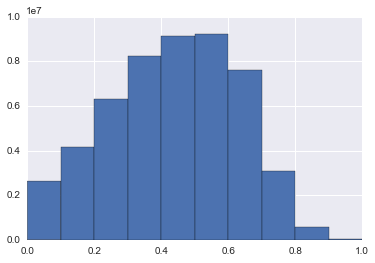

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.hist(np.ravel(q))